In [1]:
### TO RUN
import os

import matplotlib.pyplot as plt
import numpy as np
import pickle

"Machine learning tools"

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS

Useful functions to select, read and play the dataset sounds are provided in the ``classification`` directory. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 3. Probability vector and memory  [~30min-1h] </font> <br>

In [2]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))

background
birds
chainsaw
fire
fireworks-00
fireworks-01
fireworks-02
fireworks-03
fireworks-04
fireworks-05
fireworks-06
fireworks-07
fireworks-08
fireworks-09
fireworks-10
fireworks-11
fireworks-12
fireworks-13
fireworks-14
fireworks-15
fireworks-16
fireworks-17
fireworks-18
fireworks-19
fireworks-20
fireworks-21
fireworks-22
fireworks-23
fireworks-24
fireworks-25
fireworks-26
fireworks-27
fireworks-28
fireworks-29
fireworks-30
fireworks-31
fireworks-32
fireworks-33
fireworks-34
fireworks-35
fireworks-36
fireworks-37
fireworks-38
fireworks-39
gun-01
gun-02
gun-03
gun-04
gun-05
gun-06
gun-07
gun-08
gun-09
gun-10
gun-11
gun-12
gun-13
gun-14
gun-15
gun-16
gun-17
gun-18
gun-19
gun-20
gun-21
gun-22
gun-23
gun-24
gun-25
gun-26
gun-27
gun-28
gun-29
gun-30
gun-31
gun-32
gun-33
gun-34
gun-35
gun-36
gun-37
gun-38
gun-39
handsaw
helicopter


In [3]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

<font size=5 color=#009999> 3.1. Probability vector </font> <br>

A clear drawback of the models considered in ``hands_on_classif2_audio_student.ipynb`` is that they only output the most probable class, but do not provide any confidence estimate of this prediction. It is generally better to output a vector of probabilities for all the classes at each prediction, hence allowing the models to hesitate between different classes. 
Remember a vector of probability can be defined as 

\begin{equation*}
    \mathbb P \{ i \} \in [0,1], ~~\sum_i \mathbb P \{ i \} = 1. 
\end{equation*}

There are many ways to do so:

- **Adapt the models**, e.g. for the ``KNN`` classifier, give the probability of class ``i`` as the ratio between the number of neighbours with label ``i`` and the total number of considered neighbours ``K``.
- **Use other models**: a ``CNN`` classifier is suited for outputting probability values for each class.
- **Compare with old predictions**: the probability of class ``i`` may simply be given as the ratio of its appearances in the (arbitrarily chosen) ``N`` last predictions.

The last bullet implies the use of old predictions to compute a probability estimate. This leads to the notion of memory in the predictions, that we discuss in the second part of this notebook.

Let us start by creating a dataset ``myds`` and taking the model trained in ````hands_on_classif2_audio.ipynb````.

Don't forget to normalize your feature vectors as well as reduce their dimensionality if you trained your model with such data.

In [4]:
### TO COMPLETE - Uncomment the following line
model_dir = "data/models/"
filename = "model.pickle"
model_knn = pickle.load(open(model_dir + filename, "rb"))
normalize = True
pca = None


"Creation of the dataset"
myds = Feature_vector_DS(
    dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0, normalize=normalize, pca=pca
)

Open-Source code makes life easy! The ``KNeighborsClassifier`` from Sklearn already contains a ``predict_proba`` method. Start getting some intuition on this probability vector by playing with the chosen feature vector. <br>

Run the following code many times by changing  ``cls_index``. <br>

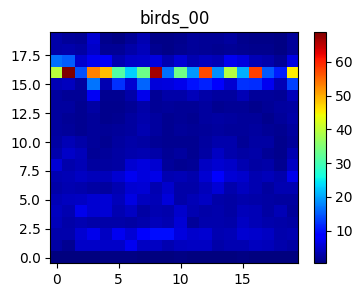

Class predicted by KNN: birds


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (85,) and arg 1 with shape (5,).

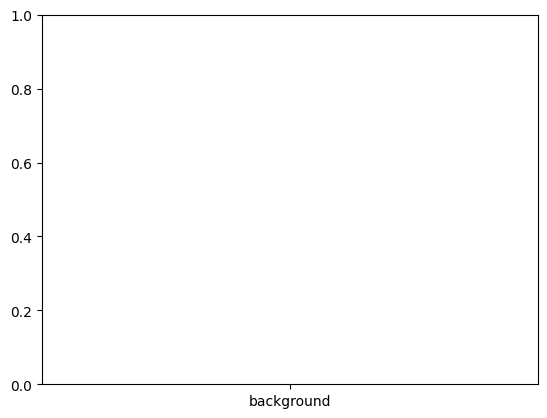

In [5]:
### TO RUN
cls_index = ["birds", 0]
myds.display(cls_index)
thisfv = myds.__getitem__(cls_index).reshape(-1)

# this artefact is necessary because the 'predict' function expects a matrix_like input.
mat = np.zeros((2, len(thisfv)))
mat[0] = thisfv

prediction_knn = model_knn.predict(mat)
print("Class predicted by KNN:", prediction_knn[0])

proba_knn = model_knn.predict_proba(mat)
plt.figure()
plt.bar(classnames, proba_knn[0])
plt.title("Probability of each class")
plt.show()

**Question**:
When the classifier miss-predicts, how distributed is the probability vector? Is it good news? How can we exploit that probability distribution for the prediction?

In [13]:
### TO COMPLETE

<font size=6 color=#009999> 3.2. Memory </font> <br>

No matter if the predictions are one class only or probability vectors, as it is natural that consecutive feature vectors belong to the same class if the sound type changes slowlier than the duration of a feature vector, it can be helpful to link consecutive predictions and see how similar they are to either strengthen or decrease our confidence in the current guess. <br>

Here, we will compare the predictions made on consecutive feature vectors belonging to the same 5s-long sound. 
Run the following code with different ``class_id``'s and different ``num``.

In [12]:
### TO RUN
model_dir = "data/models/"
filename = "model.pickle"
model_knn = pickle.load(open(model_dir + filename, "rb"))

num = 6  # 0 (default), 1, ..., 39

sound = dataset["helicopter", num]
audio = AudioUtil.open(sound)
audio = AudioUtil.resample(audio, 11025)
AudioUtil.play(audio)

"Bar charts for each window"
n_win = 5
probs = np.zeros((n_win, len(classnames)))
for window in range(n_win):
    sub_aud = (audio[0][window * 11025 :], audio[1])
    sub_aud = AudioUtil.pad_trunc(sub_aud, 950)
    sgram = AudioUtil.melspectrogram(sub_aud, Nmel=20, Nft=512)
    ncol = int(1000 * 11025 / (1e3 * 512))
    sgram = sgram[:, :ncol]
    fv = sgram.reshape(-1)
    fv = fv / np.linalg.norm(fv)

    ### TO COMPLETE - Eventually normalize and reduce feature vector dimensionality

    probs[window, :] = model_knn.predict_proba([fv])[0]

"Mean bar chart"
plt.figure()
for window in range(n_win):
    plt.bar(
        np.arange(len(classnames)) * 2 * n_win + window,
        probs[window, :],
        alpha=0.9,
        label=f"Window {window}",
    )
plt.legend()
plt.gca().set_xticks(np.arange(len(classnames)) * 2 * n_win + 2)
plt.gca().set_xticklabels(classnames)
plt.show()

plt.figure()
plt.bar(np.arange(len(classnames)), np.mean(probs, axis=0))
plt.gca().set_xticks(np.arange(len(classnames)))
plt.gca().set_xticklabels(classnames)
plt.show()

NameError: name 'folder_path' is not defined

### Question:
Are the bar plots similar between the 5 windows of the same 5s-long sound? With the default sound, how often does the right class win?

In [22]:
### TO COMPLETE
# with the default sound, the model is right 80% of the time, this plot is interesting as we can visualise when the model is confidant
# and when it is confused

### If it is relevant to combine $N$ consecutive feature vectors, there are many ways to output a prediction from it:
- **Naive**: select the class that has the highest probability among all the considered feature vectors.
- **Majority voting**: simply select the class that appears most often as the maximum probability of a feature vector.
- **Average the feature representation**: compute the average of all feature vectors and classify from this average.
- **Maximum Likelihood**: take a probabilistic approach and consider selecting class $i$ as
    $$
        \text{argmax}_i~ \log \bigg(\prod_{n=0}^{N-1} P(y[n]=i) \bigg)
        = \text{argmax}_i~ \sum_{n=0}^{N-1} \log P(y[n]=i)
    $$
    with $y[n]$ the model prediction for the feature vector $n$.

It will be part of your work to decide how you want to exploit the time information in your predictions.

Now you have all the necessary material to test a new classification model and make some objective analysis of its performances. <br>
Follow the instructions on Moodle [written here](https://moodle.uclouvain.be/mod/assign/view.php?id=204607) to see what is expected in your ``fifth report (R5)``. <br>
A lot of other classification models are already implemented by SKlearn, check the [SKlearn API](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Don't hesitate to read some opinions and discussions on the forums or even articles to help you in the model choice. The most motivated of you are even allowed to give a try to more than one additional model, it is time smartly invested for the upcoming weeks of this project! Although we expect only one characterization in the ``R5``.

Also, don't hesitate to get information from the Internet to learn how people use to deal with sound classification. We mention for example this idea of transfer learning that could be interesting for you in the second semester: https://www.youtube.com/watch?v=uCGROOUO_wY&t=1s 

In [23]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS


#need .pickle in the same directory
#and src folder stored inside LELEC210X_GROUP_E/classification


model_dir = "data/models/"
filename = "model.pickle"
model = pickle.load(open(model_dir + filename, "rb"))


def mel_vect_to_proba(list_mel_vec):
    """ 
    takes a list of 10 mel vectors and returns the class probabilities and the predicted class using average voting.
    """
    probs = np.zeros((10,5))
    for i in range(10):
        current_vec = list_mel_vec[i]
        current_vec = np.array(current_vec)
        normalized = current_vec / np.linalg.norm(current_vec)
        probs[i] = model.predict_proba([normalized]) # class are in this order : birds, chainsaw, fire, handsaw, helicopter
    mean_probs = np.mean(probs, axis=0)
    classes = ["birds", "chainsaw", "fire", "handsaw", "helicopter"]
    predicted_class = classes[np.argmax(mean_probs)]
    return mean_probs, predicted_class

In [24]:
# plotting all the spectrogram

In [25]:
### TO RUN
import os

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy

### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))

### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol
myds.shift_pct = 1


birds
chainsaw
fire
handsaw
helicopter


RuntimeError: Can not put single artist in more than one figure

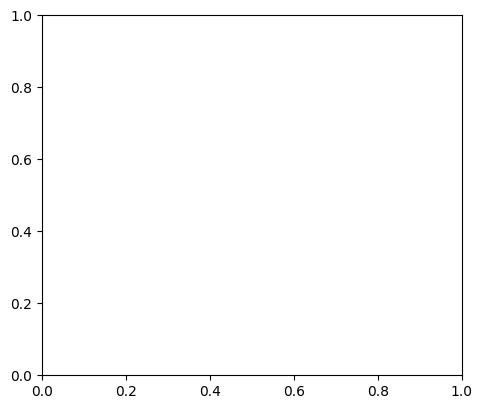

In [28]:
from matplotlib.patches import Rectangle
import numpy as np
from scipy.signal import correlate2d

def find_melvector_in_reference(reference, target):
    """
    Searches for the best match of the target melvector in the reference matrix.
    
    :param reference: np.ndarray, the reference melvector matrix (n x 20).
    :param target: np.ndarray, the melvector to locate (20 x 20).
    :return: tuple (best_row, best_col, min_difference), location and score of the best match.
    """
    # Ensure both arrays are numpy arrays
    reference = np.array(reference)
    target = np.array(target)

    # Get dimensions
    ref_rows, ref_cols = reference.shape
    target_rows, target_cols = target.shape

    if ref_cols != target_cols:
        raise ValueError("Reference and target must have the same number of columns (20).")

    best_score = float('inf')  # Smaller is better for MSE
    best_row = -1

    # Sliding window over the reference matrix
    for i in range(ref_rows - target_rows + 1):
        # Extract a window from the reference
        window = reference[i:i+target_rows, :]
        # Calculate Mean Squared Error (MSE) between the window and the target
        mse = np.mean((window - target) ** 2)
        if mse < best_score:
            best_score = mse
            best_row = i

    return best_row, best_score

myclass = "helicopter"
cls_index = [myclass, 0]
sound = dataset.__getitem__(cls_index)
name = dataset.__getname__(cls_index)
audio = AudioUtil.open(sound)
audio2 = AudioUtil.resample(audio, 11025)
melspec = AudioUtil.melspectrogram(audio2, fs2=11025)
norm = np.linalg.norm(melspec, 'fro')
melspec = melspec/norm
fig = plt.figure(figsize=(15, 4))
ax2 = fig.add_axes([0.38, 0.05, 0.28, 0.9])


# Dimensions du cadre en pourcentage
step = 500/107
stepy = 2000/20
delta = 22
start = 75
x1_pct, y1_pct = step*start, 0  # Coordonnées en pourcentage (exprimées entre 0 et 100)
x2_pct, y2_pct = step*(start+delta), 2000

# Convertir les pourcentages en dimensions réelles
x_min, x_max = ax2.get_xlim()  # Limites réelles de l'axe x
y_min, y_max = ax2.get_ylim()  # Limites réelles de l'axe y

x1 = x_min + (x_max - x_min) * (x1_pct / 100)
x2 = x_min + (x_max - x_min) * (x2_pct / 100)
y1 = y_min + (y_max - y_min) * (y1_pct / 100)
y2 = y_min + (y_max - y_min) * (y2_pct / 100)

# Ajouter un cadre
rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='green', facecolor='none')
ax2.add_patch(rect)

# Dimensions du cadre en pourcentage
step = 500/107
stepy = 2000/20
delta = 22
start = 10
x1_pct, y1_pct = step*start, 0  # Coordonnées en pourcentage (exprimées entre 0 et 100)
x2_pct, y2_pct = step*(start+delta), 2000

# Convertir les pourcentages en dimensions réelles
x_min, x_max = ax2.get_xlim()  # Limites réelles de l'axe x
y_min, y_max = ax2.get_ylim()  # Limites réelles de l'axe y

x1 = x_min + (x_max - x_min) * (x1_pct / 100)
x2 = x_min + (x_max - x_min) * (x2_pct / 100)
y1 = y_min + (y_max - y_min) * (y1_pct / 100)
y2 = y_min + (y_max - y_min) * (y2_pct / 100)

# Ajouter un cadre
rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='purple', facecolor='none')
ax2.add_patch(rect)

plot_specgram(melspec, ax2, is_mel=True, tf=len(audio2[0]) / audio2[1])
plt.savefig(myclass+"-wav.pdf")

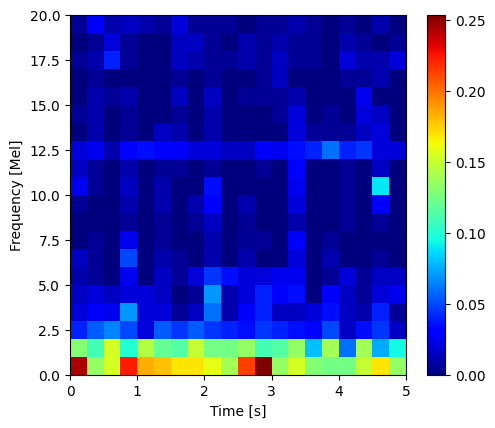

In [27]:
myclass = "helicopter"
filename = "../melvecs/jack/"+myclass+"_jack.npy"  # Remplace par le chemin réel de ton fichier
data = np.load(filename, allow_pickle=True)  # Utiliser allow_pickle=True si le fichier contient des objets Python
data = data.item()
melspec = data["melvec"]  # Récupérer la matrice
norm = np.linalg.norm(melspec, 'fro')
melspec = melspec/norm
fig = plt.figure(figsize=(15, 4))
ax2 = fig.add_axes([0.38, 0.05, 0.28, 0.9])


plot_specgram(melspec, ax2, is_mel=True, tf=len(audio2[0]) / audio2[1])
plt.savefig(myclass+"-jack.pdf")

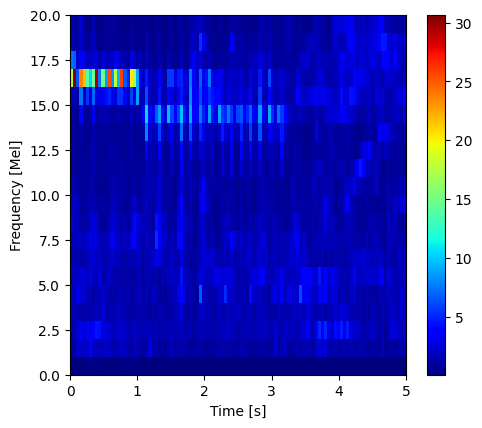

In [29]:
myclass = "helicopter"
filename = "melvecs/birds/data_aquired_birds_0_0.npy"  # Remplace par le chemin réel de ton fichier
data = np.load(filename, allow_pickle=True)  # Utiliser allow_pickle=True si le fichier contient des objets Python
melspec = data
fig = plt.figure(figsize=(15, 4))
ax2 = fig.add_axes([0.38, 0.05, 0.28, 0.9])
melspec = melspec.reshape(20, 20)
melspec = np.rot90(melspec, k=-1)

# Dimensions du cadre en pourcentage
step = 500/107
stepy = 2000/20
x1_pct, y1_pct = step*25, 0  # Coordonnées en pourcentage (exprimées entre 0 et 100)
x2_pct, y2_pct = step*85, 2000


# plot_specgram(melspec, ax2, is_mel=True, tf=len(audio2[0]) / audio2[1])
# plt.savefig(myclass+"-mic.pdf")


#-----------------------------------------------------------------------------------
num = 0  # 0 (default), 1, ..., 39

sound = dataset["birds", num]
audio = AudioUtil.open(sound)
audio = AudioUtil.resample(audio, 11025)

sgram = AudioUtil.melspectrogram(audio, Nmel=20)
plot_specgram(sgram, ax2, is_mel=True, tf=len(audio2[0]) / audio2[1])
plt.savefig("birds_mic.png")

In [ ]:
from sklearn.svm import SVC
# X = matrix with 12*5 mel vectors
X = np.zeros((12*5, 400))

classes = ["birds", "chainsaw", "handsaw", "fire", "helicopter"]
index = 0

for cls in classes:
    filenames = [
        f"../melvecs/{cls}/{cls}_1.npy",
        f"../melvecs/{cls}/{cls}_1n.npy",
        f"../melvecs/{cls}/{cls}_2.npy",
        f"../melvecs/{cls}/{cls}_2n.npy",
        f"../melvecs/{cls}/{cls}_3.npy",
        f"../melvecs/{cls}/{cls}_3n.npy",
        f"../melvecs/{cls}/{cls}_4.npy",
        f"../melvecs/{cls}/{cls}_4n.npy",
        f"../melvecs/{cls}/{cls}_6.npy",
        f"../melvecs/{cls}/{cls}_6n.npy",
        f"../melvecs/{cls}/{cls}_7.npy",
        f"../melvecs/{cls}/{cls}_7n.npy"
    ]

    for filename in filenames:
        data = np.load(filename, allow_pickle=True)  # Utiliser allow_pickle=True si le fichier contient des objets Python
        data = data.item()
        melspec = data["melvec"]  # Récupérer la matrice
        fv = melspec.flatten()  # feature vector
        fv = fv.astype(np.float64)
        fv /= np.linalg.norm(fv)
        X[index] = fv
        index += 1
        
# y = classes of the mel vectors so 12 * birds, 12 * chainsaw, 12 * handsaw, 12 * fire, 12 * helicopter
y = np.array(["birds"] * 12 + ["chainsaw"] * 12 + ["handsaw"] * 12 + ["fire"] * 12 + ["helicopter"] * 12)

best_C = 100
best_gamma = 0.01
best_kernel = "rbf"
model = SVC(C=best_C, gamma=best_gamma, kernel=best_kernel, probability=True)
model.fit(X,y)


# Create the test set
X_test = np.zeros((3*5, 400))
index = 0

for cls in classes:
    filenames = [
        f"../melvecs/{cls}_test/{cls}_8.npy",
        f"../melvecs/{cls}_test/{cls}_9.npy",
        f"../melvecs/{cls}_test/{cls}_10.npy"
    ]

    for filename in filenames:
        data = np.load(filename, allow_pickle=True)  # Utiliser allow_pickle=True si le fichier contient des objets Python
        data = data.item()
        melspec = data["melvec"]  # Récupérer la matrice
        fv = melspec.flatten()  # feature vector
        fv = fv.astype(np.float64)
        fv /= np.linalg.norm(fv)
        X_test[index] = fv
        index += 1

# y_test = classes of the mel vectors so 3 * birds, 3 * chainsaw, 3 * handsaw, 3 * fire, 3 * helicopter
y_test = np.array(["birds"] * 3 + ["chainsaw"] * 3 + ["handsaw"] * 3 + ["fire"] * 3 + ["helicopter"] * 3)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(model.predict(X_test))
print(f"Test set accuracy: {accuracy * 100:.2f}%")